# Libraries

In [1]:
import time
import datetime
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
from IPython.display import HTML
from sklearn.mixture import GaussianMixture
import os
import matplotlib.cm as cm


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('Device name:',device)

Device name: cuda:0


# Data preparation

In [2]:
# Define default data type for tensors
dtype = torch.float32  # Change to torch.double if float64 precision is preferred

# Load experimental data from a CSV file
# Specify the full file path where 'All_Data_frames.csv' is located
data = pd.read_csv('../All_Data_frames.csv')
print(data.tail())  # Display the last few rows of the dataset


##### Filter data for a specific colony and ant size ####
num_colony = 620  # Colony ID
size_ant = 'L'  # Ant size category
temp = data.loc[(data.Colony == num_colony) & (data.SizeClass == size_ant)][['xcor_mm', 'ycor_mm']]


# Define time step and subsampling factor
num_mul = 30  # Time sampling factor
dt = 1 / 29.97 * num_mul  # Time step (seconds)

# Convert position data to tensor format (meters) and downsample
data_x = torch.tensor(temp.to_numpy()[:, 0] / 1000, dtype=dtype).reshape(-1, 16)  # X-coordinates (m)
data_x = data_x[::num_mul, :]  # Apply sampling
data_y = torch.tensor(temp.to_numpy()[:, 1] / 1000, dtype=dtype).reshape(-1, 16)  # Y-coordinates (m)
data_y = data_y[::num_mul, :]  # Apply sampling

# Generate time sequence tensor
data_t = torch.linspace(0, dt * (data_x.shape[0] - 1), data_x.shape[0], dtype=dtype)

# Delete original data to free memory
del data

         AntID     xcor_mm     ycor_mm  Time_frame  Colony SizeClass
40706715   V12 -266.888916   41.477314      106082     704         S
40706716   V13 -204.648226  147.555599      106082     704         S
40706717   V14 -143.306903 -195.905235      106082     704         S
40706718   V15 -260.857649  -76.024630      106082     704         S
40706719   V16  -14.788834 -215.886498      106082     704         S


# Define the CustomDataset Class

In [3]:
class CustomDataset(Dataset):
    """
    Custom dataset class for handling time-sequenced position data.
    """

    def __init__(self, data_x, data_y, data_t):
        """
        Initialize the dataset with time (data_t), x-coordinates (data_x), and y-coordinates (data_y).

        Args:
            data_x (Tensor): X-coordinates of the ant positions.
            data_y (Tensor): Y-coordinates of the ant positions.
            data_t (Tensor): Time steps corresponding to position data.
        """
        self.data_t = data_t
        self.data_x = data_x
        self.data_y = data_y
    
    def __len__(self):
        """
        Returns the number of data points in the dataset.
        """
        return len(self.data_t)
    
    def __getitem__(self, idx):
        """
        Retrieves a single data interval (time, x-position, y-position).

        Args:
            idx (int): Index of the data point.

        Returns:
            t_train, x_train, y_train corresponding to time, x-coordinate, and y-coordinate.
        """
        t_train = self.data_t[idx]
        x_train = self.data_x[idx]
        y_train = self.data_y[idx]
        
        return t_train, x_train, y_train


# Trajectory, footprint concentration, Perception-response strategy networks

In [4]:
"""
Trajectory networks
"""

# Define a small positive constant to prevent division by zero
# Change to a different value if needed for numerical stability
eps = 1e-9  

class PINN_ODE(nn.Module):
    """
    Neural Network for training Ordinary Differential Equations (ODEs).
    """

    def __init__(self, input_num, output_num, bias=True):
        """
        Initializes the neural network model.

        Args:
            input_num (int): Number of input features.
            output_num (int): Number of output features (2 * number of ants).
            bias (bool): Whether to use bias in linear layers.
        """
        super().__init__()

        self.num_ants = output_num // 2  # Number of ants (each ant has x and y coordinates)
        self.bias = bias

        # Define fully connected layers
        self.fc1 = nn.Linear(input_num, 32, bias=bias)
        self.fc2 = nn.Linear(32, 32, bias=bias)
        self.fc3 = nn.Linear(32, 32, bias=bias)
        self.fc4 = nn.Linear(32, output_num, bias=bias)

        self.reset_parameters()  # Initialize weights and biases

    def forward(self, x):
        """
        Forward pass through the neural network.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Predicted output.
        """
        self.input = x  # Store input values

        # Normalize input data (-1 to 1)
        x = (x - 50) / 50

        # Pass through fully connected layers with activation functions
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x) * (1e-1)  # Scale output

        return x

    def reset_parameters(self) -> None:
        """
        Initializes network parameters using Xavier uniform initialization.
        """
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc4.weight, gain=1)

        if self.bias:
            nn.init.constant_(self.fc1.bias, 0.0)
            nn.init.constant_(self.fc2.bias, 0.0)
            nn.init.constant_(self.fc3.bias, 0.0)
            nn.init.constant_(self.fc4.bias, 0.0)

    def loss(self, x_ode, data_exp):
        """
        Computes the loss function.

        Args:
            x_ode (Tensor): Input tensor representing time.
            data_exp (Tensor): Experimental data for comparison.

        Returns:
            Tensor: Computed loss value.
        """
        pred1 = self.forward(x_ode)  # Model predictions
        num_ant = pred1.shape[1] // 2  # Number of ants

        loss_func = nn.MSELoss().to(device)  # Mean Squared Error loss function

        # Extract x and y positions from predicted output
        pos_x = pred1[:, 0:num_ant]
        pos_y = pred1[:, num_ant:]

        # Compute the magnitude of position vectors
        self.r_mag = torch.sqrt(torch.square(pos_x) + torch.square(pos_y))

        ####### Compute velocity of ants #########
        for i in range(pred1.size(1)):
            temp = torch.zeros_like(pred1)
            temp[:, i] = 1
            grads, = autograd.grad(pred1, self.input, grad_outputs=temp, create_graph=True)
            if i == 0:
                self.u = grads  # Initialize velocity tensor
            else:
                self.u = torch.hstack((self.u, grads))  # Stack velocity components

        # Extract velocity components
        self.vel_x = self.u[:, 0:num_ant]
        self.vel_y = self.u[:, num_ant:]

        # Compute velocity magnitude
        self.u_mag = torch.sqrt(torch.square(self.vel_x) + torch.square(self.vel_y))

        # Normalize velocity components to obtain unit vectors
        self.vel_x_unit = self.vel_x / self.u_mag
        self.vel_y_unit = self.vel_y / self.u_mag

        ####### Compute acceleration of ants #########
        for i in range(pred1.size(1)):
            temp = torch.zeros_like(pred1)
            temp[:, i] = 1
            grads, = autograd.grad(self.u, self.input, grad_outputs=temp, create_graph=True)
            if i == 0:
                self.accel = grads  # Initialize acceleration tensor
            else:
                self.accel = torch.hstack((self.accel, grads))  # Stack acceleration components

        # Compute loss between predictions and experimental data
        self.loss_data = loss_func(pred1, data_exp)

        # Total loss (currently only data loss is considered)
        loss_ode = self.loss_data

        return loss_ode


def closure_ode():
    """
    Closure function for the L-BFGS optimizer.

    This function evaluates the loss function and performs backpropagation
    for updating the neural network parameters.

    Returns:
        Tensor: Computed loss value.
    """
    global loss_value_ode_LBFGS, iter_num

    model_ode.train()
    optimizer_LBFGS.zero_grad()

    # Compute ODE loss
    loss_ode = model_ode.loss(input_ode, XY_test.to(device))

    # Perform backpropagation only if loss is finite
    if torch.isfinite(loss_ode).item():
        loss_ode.backward() 

    return loss_ode


In [5]:
"""
Footprint concentration networks
"""
eps = 1e-9
class PINN_PDE(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the PDE governing
    footprint concentration dynamics.

    This network models the spatiotemporal evolution of ant footprints by learning
    from the PDE:
        ∂c/∂t = D ∇^2 c + k_p H(r; a) - k_m c
    where H is the heaviside step function representing footprint deposition at positions r, and c is the concentration.
    """

    def __init__(self, input_num, output_num, bias=True):
        """
        Initializes the PINN model.

        Args:
            input_num (int): Number of input features (typically t, x, y → 3).
            output_num (int): Number of output features (typically 1, for scalar field c).
            bias (bool): Whether to include bias in linear layers.
        """
        super().__init__()

        self.bias = bias

        # Define fully connected layers
        self.fc1 = nn.Linear(input_num, 32, bias=bias)
        self.fc2 = nn.Linear(32, 32, bias=bias)
        self.fc3 = nn.Linear(32, 32, bias=bias)
        self.fc4 = nn.Linear(32, output_num, bias=bias)

        self.reset_parameters()

        # PDE parameters
        self.kp = 0.01            # Footprint production rate
        self.km = 0.2             # Footprint decay rate
        self.ph_r = 0.03          # Production radius (approx. ant body size)
        self.boundary = 0.0       # Decision boundary for classification of active ants

    def forward(self, x):
        """
        Forward pass through the PINN.

        Args:
            x (Tensor): Input tensor of shape (N, 3) with [t, x, y].

        Returns:
            Tensor: Predicted footprint concentration c(t, x, y).
        """
        self.input = x

        # Normalize input:
        #   - Time t normalized (-1 to 1)
        #   - Space x, y normalized by arena radius (0.28 m)
        x_t = (x[:, 0:1] - 50) / 50
        x_xy = x[:, 1:] / 0.28
        x = torch.cat((x_t, x_xy), dim=1)

        # Pass through the network with tanh activations
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))

        # Final layer uses softplus to ensure positivity of output (concentration ≥ 0)
        x = F.softplus(self.fc4(x)) * 0.1  # Output scaled for stability

        return x

    def reset_parameters(self) -> None:
        """
        Initializes the network parameters using Xavier uniform initialization.
        """
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc4.weight, gain=nn.init.calculate_gain('relu'))

        if self.bias:
            nn.init.constant_(self.fc1.bias, 0.0)
            nn.init.constant_(self.fc2.bias, 0.0)
            nn.init.constant_(self.fc3.bias, 0.0)
            nn.init.constant_(self.fc4.bias, 0.0)

            
def loss(model_ode, model_pde, model_anten, x_ode, x_pde, mask):
    """
    Computes the total loss for the footprint concentration and response strategy coupled system:
    - Just recall the trajectory loss
    - PDE loss from footprint concentration
    - Normal acceleration loss from perception-response based on gradient sensing

    Args:
        model_ode (nn.Module): Trained trajectory model (PINN_ODE).
        model_pde (nn.Module): Concentration field model solving PDE for footprint concentration field (PINN_PDE).
        model_anten (nn.Module): Perception-response model (e.g., Mechanism_NN).
        x_ode (Tensor): Temporal input for trajectory model, shape (N, 1).
        x_pde (Tensor): Spatiotemporal input for concentration field model, shape (M, 3).
        mask (Tensor): Boolean mask to select agent positions from the full PDE input.

    Returns:
        loss_data (Tensor): trajectory position loss from model_ode
        loss_theta (Tensor): perception-response loss
        loss_concent (Tensor): concentration PDE residual loss
        loss_total (Tensor): total weighted loss
    """

    loss_func = nn.MSELoss().to(device)

    # Forward prediction from PDE model
    pred_pde = model_pde(x_pde)  # c(t, x, y)

    # Retrieve trajectory-related losses from the ODE model
    loss_data = model_ode.loss_data

    u_mag = model_ode.u_mag                        # Agent speed magnitude
    vel_x_unit = model_ode.vel_x_unit              # x-direction unit velocity
    vel_y_unit = model_ode.vel_y_unit              # y-direction unit velocity

    # Compute gradients of c(t, x, y)
    dc_dt_dx_dy = autograd.grad(pred_pde, x_pde, torch.ones([x_pde.shape[0], 1]).to(device), create_graph=True)[0]
    dc_dt = dc_dt_dx_dy[:, [0]]                    # ∂c/∂t
    dc_dx = dc_dt_dx_dy[:, [1]]                    # ∂c/∂x
    dc_dy = dc_dt_dx_dy[:, [2]]                    # ∂c/∂y

    # Decompose gradients in velocity-aligned directions
    dc_normal = (-vel_y_unit.reshape(-1, 1) * dc_dx[mask]) + (vel_x_unit.reshape(-1, 1) * dc_dy[mask])     # Concentration gradeint normal to velocity
    dc_parallel = (vel_x_unit.reshape(-1, 1) * dc_dx[mask]) + (vel_y_unit.reshape(-1, 1) * dc_dy[mask])    # Concentration gradeint parallel to velocity

    # Select dc_normal entries for active ants
    dc_normal_sel = (dc_normal.reshape(-1, 16)[1:-1][mask_u_mag_tensor[1:-1]]).reshape(-1, 1)

    # Decompose acceleration
    accel_tan = (model_ode.accel[:, 0:num_ants] * (-vel_y_unit)) + (model_ode.accel[:, num_ants:] * vel_x_unit)   # acceleration normal to velocity
    accel_parallel = (model_ode.accel[:, 0:num_ants] * vel_x_unit) + (model_ode.accel[:, num_ants:] * vel_y_unit)   # acceleration parallel to velocity

    # Select acceleration and velocity magnitudes for active ants
    accel_tan_sel = accel_tan[1:-1][mask_u_mag_tensor[1:-1]]
    u_mag_sel = u_mag[1:-1][mask_u_mag_tensor[1:-1]]

    # Compute local footprint deposition strength based on distance from agents
    dist_value = torch.sqrt(torch.square(x_pde[:,1].unsqueeze(1) - 
                                         (x_pde[:,1:2][mask]).reshape(-1,num_ants).repeat_interleave(x_pde.shape[0]//x_ode.shape[0],dim=0)) +\
                            torch.square(x_pde[:,2].unsqueeze(1) - 
                                         (x_pde[:,2:3][mask]).reshape(-1,num_ants).repeat_interleave(x_pde.shape[0]//x_ode.shape[0],dim=0)))

    dist_mask = dist_value - model_pde.ph_r

    local_dist_func = torch.sum(
        torch.where(dist_mask <= 0, dist_mask, torch.zeros_like(dist_mask)) / (dist_mask+eps),
        dim=1,
        keepdim=True
    )

    # Compute production and decay terms for PDE
    f = model_pde.kp * local_dist_func - model_pde.km * pred_pde

    # Compute perception-response using local gradient sensing
    g = model_anten(dc_normal_sel)

    # Loss: rate of angle change driven by perception-response vs actual normal acceleration
    loss_theta = loss_func(accel_tan_sel.flatten(), g.flatten() * u_mag_sel.flatten())

    # PDE residual loss: ∂c/∂t ≈ f
    loss_concent = loss_func(dc_dt, f)

    # Total loss (weighted sum)
    loss_total = 1 * loss_theta + 20 * loss_concent

    return loss_data, loss_theta, loss_concent, loss_total


def closure_pde():
    """
    Closure function for L-BFGS optimization during PINN training.

    It is used by the L-BFGS optimizer to evaluate the loss and gradients 
    at each iteration.

    Returns:
        loss_total (Tensor)
    """
    global loss_value_LBFGS, iter_num, XY_test

    # Evaluate the ODE model's internal loss
    loss_ode = model_ode.loss(input_ode, data_exp=XY_test)

    # Set PDE model to training mode and clear previous gradients
    model_pde.train()
    optimizer_LBFGS.zero_grad()

    # Compute total loss and its components
    loss_data, loss_theta, loss_concent, loss_total = \
        loss(model_ode, model_pde, model_anten, input_ode, input_pde, mask)

    # Backpropagate only if the loss is finite
    if torch.isfinite(loss_total).item():
        loss_total.backward()
    else:
        pass  # Skip backward pass if loss is NaN or Inf

    return loss_total


In [6]:
"""
Perception-response networks
"""

class Mechanism_NN(nn.Module):
    """
    Neural network to infer response mechanisms from input data.

    This architecture consists of 3 fully connected layers with sigmoid activations
    in the hidden layers.
    """

    def __init__(self, input_num, output_num, bias=True):
        """
        Initializes the Mechanism_NN model.

        Args:
            input_num (int): Number of input features.
            output_num (int): Number of output features.
            bias (bool): Whether to include bias terms in linear layers.
        """
        super().__init__()

        self.bias = bias

        # Define fully connected layers
        self.fc1 = nn.Linear(input_num, 8, bias=bias)
        self.fc2 = nn.Linear(8, 8, bias=bias)
        self.fc3 = nn.Linear(8, output_num, bias=bias)

        self.reset_parameters()  # Initialize weights and biases

    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (Tensor): Input tensor of shape (batch_size, input_num).

        Returns:
            Tensor: Output tensor of shape (batch_size, output_num).
        """
        self.input = x  # Store input for external access if needed

        # Apply scaling and pass through the network
        x = self.fc1(x * 5)           # Scale input and apply first linear layer
        x = torch.sigmoid(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)              # Output layer (no activation)

        return x

    def reset_parameters(self) -> None:
        """
        Initializes weights using Xavier uniform initialization and biases to zero.
        """
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('sigmoid'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('sigmoid'))
        nn.init.xavier_uniform_(self.fc3.weight, gain=1)

        if self.bias:
            nn.init.constant_(self.fc1.bias, 0.0)
            nn.init.constant_(self.fc2.bias, 0.0)
            nn.init.constant_(self.fc3.bias, 0.0)


In [7]:
### Define time (T), x-coordinates (X), and y-coordinates (Y) ###

num_t = 100  # Number of time steps

# Create dataset and data loader for training
dataset = CustomDataset(data_x, data_y, data_t)
train_loader = DataLoader(dataset, batch_size=num_t, shuffle=False, drop_last=True)

# Classification of active and inactive ants

Group decision boundary u_mag value: 0.0054


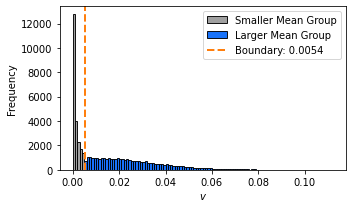

In [8]:
# Define number of ants in group
num_ants = 16

# List to store velocity magnitudes from all trained ODE models
u_mag = []

# Iterate over trajectory batches and collect u_mag from each model
for index, (t_train, x_train, y_train) in enumerate(train_loader):
    model_ode_path = '../Model/ODE/'+str(num_colony) + str(size_ant) + '_step-100s_model_ode_' + str(index)

    # Load pre-trained ODE model if it exists
    if os.path.exists(model_ode_path):
        model_ode = torch.load(model_ode_path)

    # Move model to appropriate device and precision
    model_ode = model_ode.to(device).to(dtype=data_t.dtype)

    # Prepare input tensor
    input_ode = (t_train.reshape(-1, 1) - t_train[0]).to(device).requires_grad_(True)
    XY_test = torch.hstack((x_train, y_train)).to(device)

    # Forward pass and compute internal dynamics (including u_mag)
    _ = model_ode(input_ode)
    _ = model_ode.loss(input_ode, XY_test)

    # Store velocity magnitude values
    u_mag.append(model_ode.u_mag.flatten().to('cpu').detach().numpy())

# Convert collected magnitudes to 2D NumPy array for GMM
u_mag_array = np.array(u_mag)
u_mag_np = u_mag_array.flatten().reshape(-1, 1)

# Apply Gaussian Mixture Model (GMM) with 2 components
# This separates ants into low-speed (inactive) and high-speed (active) groups
gmm = GaussianMixture(n_components=2, random_state=0, max_iter=100, init_params='kmeans')
gmm.fit(u_mag_np)

# Predict group labels
labels = gmm.predict(u_mag_np)

# Identify which group has higher average speed
group_means = gmm.means_.flatten()
larger_group_label = np.argmax(group_means)
smaller_group_label = 1 - larger_group_label

# Separate data by group label
u_mag_larger_group = u_mag_np[labels == larger_group_label].flatten()
u_mag_smaller_group = u_mag_np[labels == smaller_group_label].flatten()

# Compute decision boundary between two groups
# Boundary = midpoint between max(small group) and min(large group)
decision_boundary = (np.max(u_mag_smaller_group) + np.min(u_mag_larger_group)) / 2

print(f"Group decision boundary u_mag value: {decision_boundary:.4f}")

# Plot histogram of velocity magnitudes with color-coded groups
bins = np.arange(0, np.max(u_mag_np) + 0.001, 0.001)

color_gray = np.array([150, 150, 150]) / 255
color_blue = np.array([0, 100, 250]) / 255

plt.figure(figsize=(5, 3))

# Plot smaller group (likely inactive)
plt.hist(u_mag_smaller_group, bins=bins, color=color_gray, alpha=0.9,
         edgecolor='black', label='Smaller Mean Group')

# Plot larger group (likely active)
plt.hist(u_mag_larger_group, bins=bins, color=color_blue, alpha=0.9,
         edgecolor='black', label='Larger Mean Group')

# Draw vertical line for decision boundary
plt.axvline(x=decision_boundary, color='tab:orange', linestyle='--', linewidth=2,
            label=f'Boundary: {decision_boundary:.4f}')

# Set axis labels (no title for cleaner figure)
plt.xlabel('$v$')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


# Training

In [9]:
# Start timer and print current timestamp
tik = time.time()
now = datetime.datetime.now()
print(now)

# Training hyperparameters
num_ants = 16
epoch_adam = 100
epoch_LBFGS = 1500
patience = -51
tolerance = 5e-7

loss_pde = []
repeat_num = 5

# Iterate over trajectory batches
for index, (t_train, x_train, y_train) in enumerate(train_loader):

    for kkk in range(repeat_num):  # Repeat training attempt (for retry if failed)

        # Initialize models
        model_pde = PINN_PDE(input_num=3, output_num=1, bias=True).to(device).to(dtype=data_t.dtype)
        model_anten = Mechanism_NN(input_num=1, output_num=1, bias=True).to(device).to(dtype=data_t.dtype)
        model_ode_path = '../Model/ODE/'+str(num_colony) + str(size_ant) + '_step-100s_model_ode_' + str(index)

        # Skip if ODE model doesn't exist
        if not os.path.exists(model_ode_path):
            continue

        model_ode = torch.load(model_ode_path).to(device).to(dtype=data_t.dtype)
        params = list(model_pde.parameters()) + list(model_anten.parameters())
        optimizer_adam = torch.optim.Adam(params, lr=0.001)

        # Prepare ODE input and reference data
        input_ode = (t_train.reshape(-1, 1) - t_train[0]).to(device).requires_grad_(True)
        XY_test = torch.hstack((x_train, y_train)).to(device)

        pred_ode = model_ode(input_ode)

        # Construct PDE input from ODE prediction
        pde_t = input_ode
        pos_x = pred_ode[:, :num_ants]
        pos_y = pred_ode[:, num_ants:]

        T_pde, X_pde = torch.meshgrid(pde_t.flatten(), pos_x.flatten().clone().detach(), indexing='ij')
        _, Y_pde = torch.meshgrid(pde_t.flatten(), pos_y.flatten().clone().detach(), indexing='ij')
        input_pde = torch.vstack((T_pde.flatten(), X_pde.flatten(), Y_pde.flatten())).transpose(1,0)            
        input_pde = input_pde.clone().detach().to(device).requires_grad_(True)

        num_t = pred_ode.shape[0]

        # Create mask for active ants using u_mag and GMM decision boundary (Don't change the name 'mask_u_mag_tensor')
        model_ode.loss(input_ode, data_exp=XY_test)
        u_mag_np = model_ode.u_mag.flatten().cpu().detach().numpy().reshape(-1, 1)
        mask_u_mag = u_mag_np >= decision_boundary
        mask_u_mag_tensor = torch.tensor(mask_u_mag, dtype=torch.bool).view(model_ode.u_mag.shape).to(device)

        # Match ODE time indices to PDE time-expanded grid
        mask = torch.zeros(num_t * num_t * num_ants, 1)
        for j in range(num_t):
            start = j * (num_t * num_ants) + j * num_ants
            mask[start:start + num_ants] = 1
        mask = mask.bool().squeeze(1).to(device)

        # ----------------------- ADAM Optimization -----------------------
        loss_value_pde_adam = []

        for ii in range(epoch_adam):
            model_pde.train()
            optimizer_adam.zero_grad()

            model_ode.loss(input_ode, data_exp=XY_test)

            loss_data, loss_theta, loss_concent, loss_total = loss(
                model_ode, model_pde, model_anten, input_ode, input_pde, mask)

            if not torch.isfinite(loss_total):
                break

            loss_total.backward()
            optimizer_adam.step()

            loss_value_pde_adam.append(loss_total.item())

            if ii > abs(patience):
                recent = loss_value_pde_adam[patience:-1]
                if loss_value_pde_adam[-1] <= loss_value_pde_adam[-2] and \
                abs(loss_value_pde_adam[-1] - np.mean(recent)) < tolerance:
                    break

        # ----------------------- L-BFGS Optimization -----------------------
        loss_value_pde_lbfgs = []

        optimizer_LBFGS = torch.optim.LBFGS(params, lr=1, max_iter=20, line_search_fn='strong_wolfe')

        for i in range(epoch_LBFGS):
            loss_prev = optimizer_LBFGS.step(closure_pde)

            if not torch.isfinite(loss_prev):
                break

            loss_value_pde_lbfgs.append(loss_prev.item())

            if i > abs(patience):
                recent = loss_value_pde_lbfgs[patience:-1]
                if loss_value_pde_lbfgs[-1] <= loss_value_pde_lbfgs[-2] and \
                abs(loss_value_pde_lbfgs[-1] - np.mean(recent)) < tolerance:
                    break

        # ----------------------- Evaluation & Correlation -----------------------
        loss_data, loss_theta, loss_concent, loss_total = \
        loss(model_ode, model_pde, model_anten,input_ode, input_pde, mask = mask)
        
        model_ode.loss(input_ode, XY_test.to(device))
        pred_ode = model_ode(input_ode)
        pred_pde = model_pde(input_pde)

        dc_dt_dx_dy = autograd.grad(pred_pde, input_pde, torch.ones_like(pred_pde), create_graph=True)[0]
        dc_dx, dc_dy = dc_dt_dx_dy[:, [1]], dc_dt_dx_dy[:, [2]]

        vel_x_unit = model_ode.vel_x_unit
        vel_y_unit = model_ode.vel_y_unit

        dc_normal = (-vel_y_unit.reshape(-1, 1) * dc_dx[mask]) + (vel_x_unit.reshape(-1, 1) * dc_dy[mask])
        dc_normal_sel = (dc_normal.reshape(-1, num_ants)[1:-1][mask_u_mag_tensor[1:-1]]).reshape(-1, 1)

        accel_tan = (model_ode.accel[:, :num_ants] * -vel_y_unit) + (model_ode.accel[:, num_ants:] * vel_x_unit)
        accel_tan_sel = accel_tan[1:-1][mask_u_mag_tensor[1:-1]]
        u_mag_sel = model_ode.u_mag[1:-1][mask_u_mag_tensor[1:-1]]

        c_func = model_anten(dc_normal_sel)

        accel_tan_np = accel_tan_sel.flatten().to('cpu').detach().numpy()
        c_func_np = c_func.flatten().to('cpu').detach().numpy()
        dc_normal_np = dc_normal_sel.flatten().to('cpu').detach().numpy()
        u_mag_np = u_mag_sel.flatten().to('cpu').detach().numpy()

        # Compute correlation between predicted response and actual tangential acceleration
        corr_tan = np.corrcoef(
            accel_tan_sel.flatten().cpu().detach().numpy(),
            (c_func.flatten() * u_mag_sel.flatten()).cpu().detach().numpy()
        )[0, 1]
        
        
        """
        # Print training/evaluation status for the current step
        # L_data: Trajectory fitting loss
        # L_ang: Perception-response loss
        # L_c: Concentration field loss
        # COR_tan: Correlation between predicted and actual tangential acceleration
        """
        
        print('STEP: %d, Iter: %d, L_data: %.2e, L_ang: %.2e, L_c: %.2e, COR_tan: %.2e' %
              (index, i, model_ode.loss_data.item(), loss_theta.item(), loss_concent.item(), corr_tan))

        # Save models if training succeeds or after second attempt
        if (i > 200 and loss_concent.item() < 3e-5 and corr_tan > 0.75) or kkk == repeat_num-1:
            """
            # Optional: Visualize learned perception-response mechanism
            # Activate the # lines below to enable visualization for each interval

            """
#             fig, axs = plt.subplots(1, 2, figsize=(8, 3))

#             # Scatter plot: G(∇⊥c) vs aₙ
#             axs[0].scatter(dc_normal_np, c_func_np, s=5, label="$G(\\nabla_\\perp c)$")
#             axs[0].set_xlabel('$\\nabla_\\perp c$')
#             axs[0].set_ylabel('$a_{n}$')
#             axs[0].set_xlim(-8, 8)

#             # Scatter plot: G(∇⊥c)·|v| vs measured tangential acceleration
#             axs[1].scatter(c_func_np * u_mag_np, accel_tan_np)
#             axs[1].set_xlabel('NN($\\nabla_\\perp c$), NN($\\nabla_\\parallel c$)')
#             axs[1].set_xlim(-0.05, 0.05)

#             plt.show()

            # Save model and log loss
            model_pde.boundary = decision_boundary
            loss_pde.append(loss_concent.item())

            torch.save(model_pde, '../Model/PDE/'+str(num_colony) + size_ant + '_step-100s_model_pde_' + str(index))
            torch.save(model_anten, '../Model/PDE/'+str(num_colony) + size_ant + '_step-100s_model_anten_' + str(index))
            print('save')
            break

# Print total training time
print('time: {:.4f}s'.format(time.time() - tik))


2025-03-25 10:53:05.502548
STEP: 0, Iter: 464, L_data: 3.20e-05, L_ang: 9.75e-06, L_c: 1.23e-05, COR_tan: 9.47e-01
save
STEP: 1, Iter: 492, L_data: 2.95e-05, L_ang: 1.79e-05, L_c: 1.18e-05, COR_tan: 8.72e-01
save
STEP: 2, Iter: 509, L_data: 3.47e-05, L_ang: 1.55e-05, L_c: 1.36e-05, COR_tan: 9.05e-01
save
STEP: 3, Iter: 531, L_data: 2.55e-05, L_ang: 1.07e-05, L_c: 1.18e-05, COR_tan: 9.49e-01
save
STEP: 4, Iter: 429, L_data: 3.88e-05, L_ang: 1.04e-05, L_c: 1.42e-05, COR_tan: 9.38e-01
save
STEP: 5, Iter: 424, L_data: 2.59e-05, L_ang: 2.01e-05, L_c: 1.25e-05, COR_tan: 8.98e-01
save
STEP: 6, Iter: 607, L_data: 2.74e-05, L_ang: 8.27e-06, L_c: 1.10e-05, COR_tan: 9.42e-01
save
STEP: 7, Iter: 400, L_data: 3.34e-05, L_ang: 1.62e-05, L_c: 1.24e-05, COR_tan: 8.72e-01
save
STEP: 8, Iter: 316, L_data: 2.59e-05, L_ang: 1.13e-05, L_c: 1.10e-05, COR_tan: 9.03e-01
save
STEP: 9, Iter: 558, L_data: 2.18e-05, L_ang: 1.12e-05, L_c: 1.21e-05, COR_tan: 8.90e-01
save
STEP: 10, Iter: 399, L_data: 2.06e-05, L_an